<a href="https://colab.research.google.com/github/stonkpab/df-detect/blob/main/heatmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install keract

In [ ]:
import joblib
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import keract
import tensorflow.keras.backend as K
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
x_test_raw = joblib.load('/content/drive/My Drive/extracted2/x_test.pkl')

In [ ]:
model = keras.models.load_model('/content/drive/My Drive/extracted2/model.h5')

In [ ]:
x_test = np.array([x_test_raw[x:x+5] for x in range(0, len(x_test_raw),5)])

In [ ]:
del x_test_raw

In [ ]:
x_test.shape

(200, 5, 299, 299, 3)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_8 (TimeDist (None, 5, 10, 10, 2048)   20861480  
_________________________________________________________________
time_distributed_9 (TimeDist (None, 5, 8, 8, 64)       1179712   
_________________________________________________________________
time_distributed_10 (TimeDis (None, 5, 4, 4, 64)       0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 5, 1024)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 256)            1311744   
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_7 (Dense)              (None, 256)              

In [ ]:
test = np.expand_dims(x_test[150],axis=0)
test.shape

(1, 5, 299, 299, 3)

In [ ]:
def heatmaps(activations, input_images, directory='.', save=False, fix=True):
    """
    Plot heatmaps of activations for all filters overlayed on the input image for each layer
    :param activations: dict mapping layers to corresponding activations with the shape
    (1, output height, output width, number of filters)
    :param input_images: numpy array, input image for the overlay
    :param save: bool, if the plot should be saved
    :param fix: bool, if automated checks and fixes for incorrect images should be run
    :param directory: string - where to store the activations (if save is True)
    :return: None
    """
    for n in range(5):
        data_format = K.image_data_format()
        input_image = input_images[n]
        if fix:
            # fixes common errors made when passing the image
            # I recommend the use of keras' load_img function passed to np.array to ensure
            # images are loaded in in the correct format
            # removes the batch size from the shape
            if len(input_image.shape) == 4:
                input_image = input_image.reshape(input_image.shape[1], input_image.shape[2], input_image.shape[3])
            # removes channels from the shape of grayscale images
            if len(input_image.shape) == 3 and input_image.shape[2] == 1:
                input_image = input_image.reshape(input_image.shape[0], input_image.shape[1])

        index = 0
        act = activations[n]
        if act.shape[0] != 1:
            print('-> Skipped. First dimension is not 1.')
            continue
        if len(act.shape) <= 2:
            print('-> Skipped. 2D act.')
            continue
        print('')
        nrows = int(math.sqrt(act.shape[-1]) - 0.001) + 1  # best square fit for the given number
        ncols = int(math.ceil(act.shape[-1] / nrows))
        fig, axes = plt.subplots(nrows, ncols, figsize=(12, 12))
        fig.suptitle("Frame " + str(n+1))
        # computes values required to scale the activations (which will form our heat map) to be in range 0-1
        scaler = MinMaxScaler()
        # reshapes to be 2D with an automaticly calculated first dimension and second
        # dimension of 1 in order to keep scikitlearn happy
        scaler.fit(act.reshape(-1, 1))
        maxi = 0
        # loops over each filter/neuron
        for i in range(nrows * ncols):
            if i < act.shape[-1]:
                if len(act.shape) == 3:
                    # gets the activation of the ith layer
                    if data_format == 'channels_last':
                        img = act[0, :, i]
                    elif data_format == 'channels_first':
                        img = act[0, i, :]
                    else:
                        raise Exception('Unknown data_format.')
                elif len(act.shape) == 4:
                    if data_format == 'channels_last':
                        img = act[0, :, :, i]
                    elif data_format == 'channels_first':
                        img = act[0, i, :, :]
                    else:
                        raise Exception('Unknown data_format.')
                else:
                    raise Exception('Expect a tensor of 3 or 4 dimensions.')

                # scales the activation (which will form our heat map) to be in range 0-1 using
                # the previously calculated statistics
                if len(img.shape) == 1:
                    img = scaler.transform(img.reshape(-1, 1))
                else:
                    img = scaler.transform(img)
                # print(img.shape)
                img = Image.fromarray(img)
                # resizes the activation to be same dimensions of input_image
                img = img.resize((input_image.shape[1], input_image.shape[0]), Image.LANCZOS)
                img = np.array(img)
                if hasattr(axes, 'flat'):
                    #normalize from range (-1,1) to (0,1)
                    axes.flat[i].imshow((input_image+1)/2)
                    # overlay the activation at 70% transparency  onto the image with a heatmap colour scheme
                    # Lowest activations are dark, highest are dark red, mid are yellow
                    axes.flat[i].imshow((img+1)/2, alpha=0.3, cmap='jet', interpolation='bilinear')
                else:
                    axes.imshow((input_image+1)/2)
                    axes.imshow((img+1)/2, alpha=0.3, cmap='jet', interpolation='bilinear')
            # axis off.
            axes.flat[i].axis('off') if hasattr(axes, 'flat') else axes.axis('off')
    plt.show()
    index += 1
    plt.close(fig)

In [ ]:
activations = keract.get_activations(model, test, layer_names="time_distributed_9", nodes_to_evaluate=None, output_format='simple', nested=False, auto_compile=True)

In [ ]:
new_activations = np.squeeze(activations["time_distributed_9"],axis = 0)
new_activations.shape

(5, 8, 8, 64)

In [ ]:
act1, act2, act3, act4, act5 = np.array_split(new_activations,5)

In [ ]:
act1.shape

(1, 8, 8, 64)

In [ ]:
new = {}
new["time_distributed_9"] = act1

In [ ]:
x_test[150].shape

(5, 299, 299, 3)

In [ ]:
t1, t2, t3, t4, t5 = np.array_split(x_test[150],5)

In [ ]:
sd = [act1,act2,act3,act4,act5]

In [ ]:
sd[0].shape

(1, 8, 8, 64)

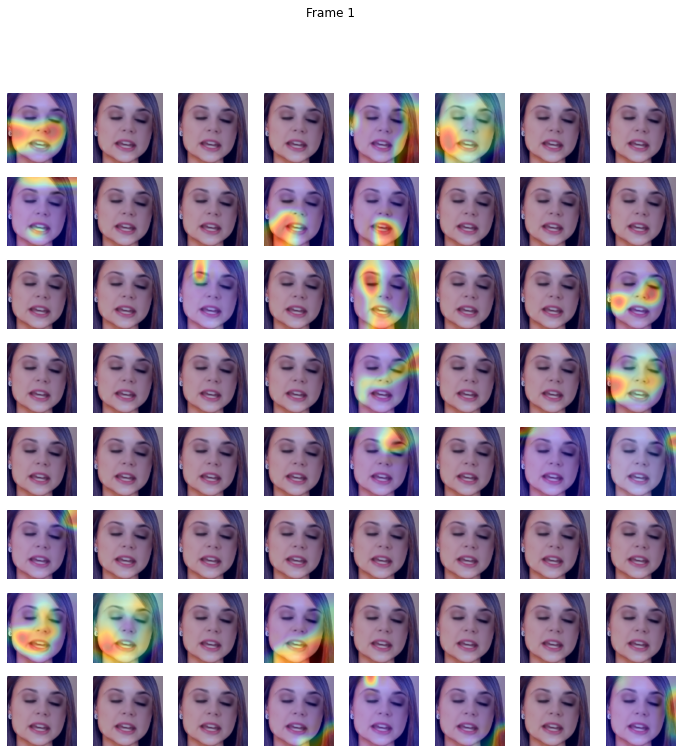

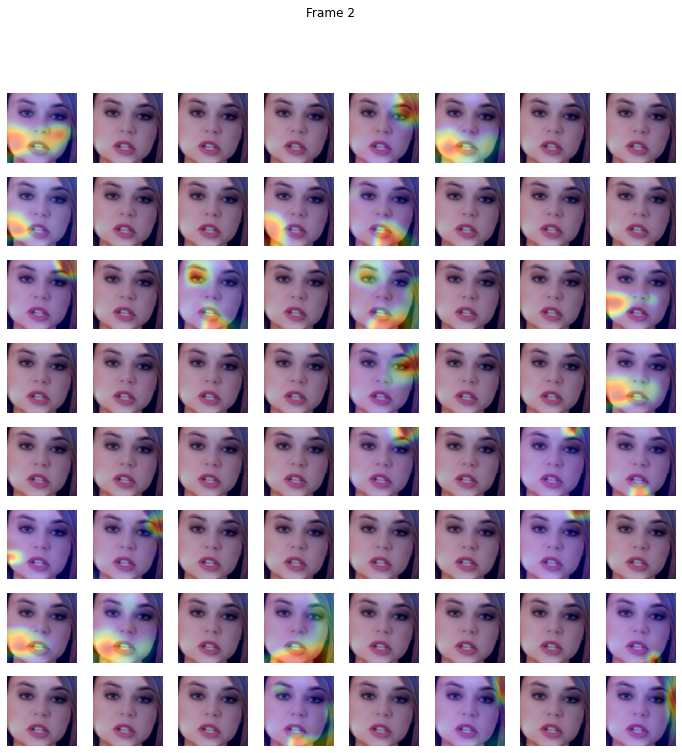

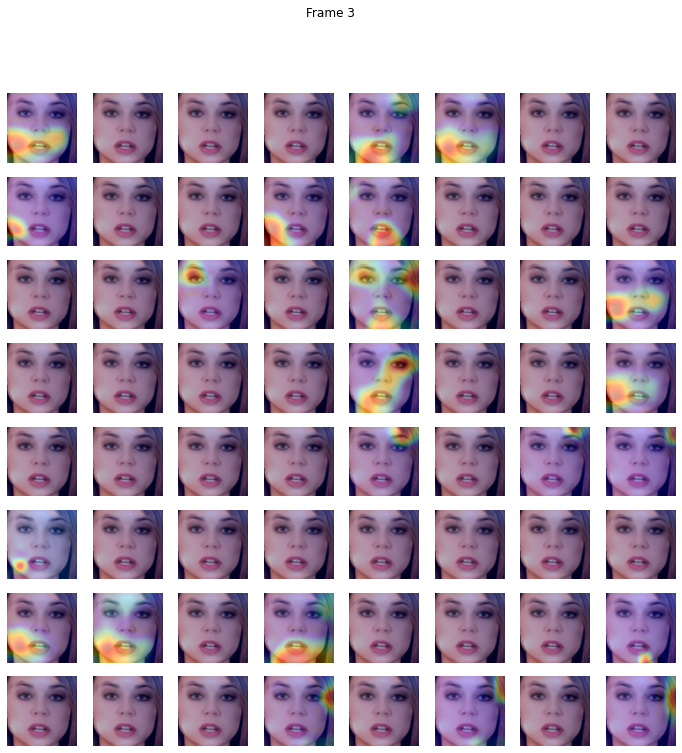

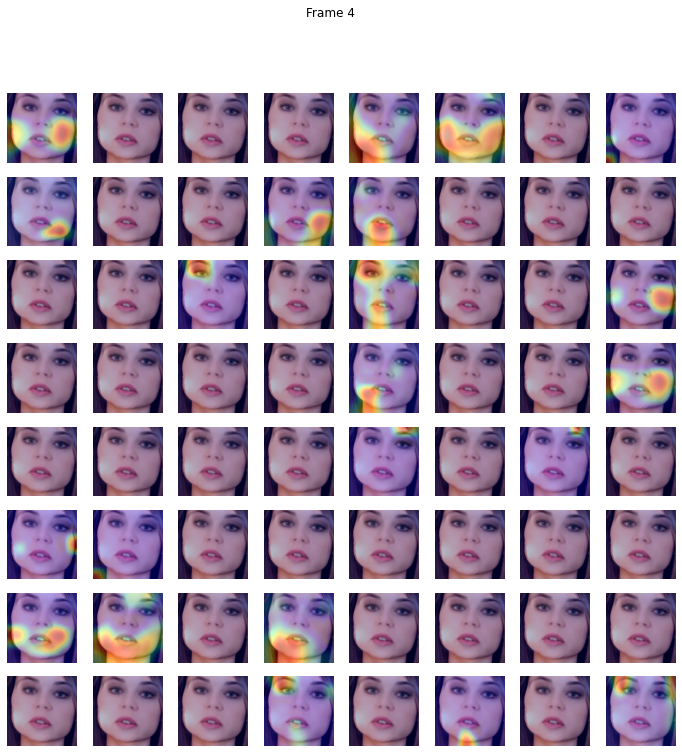

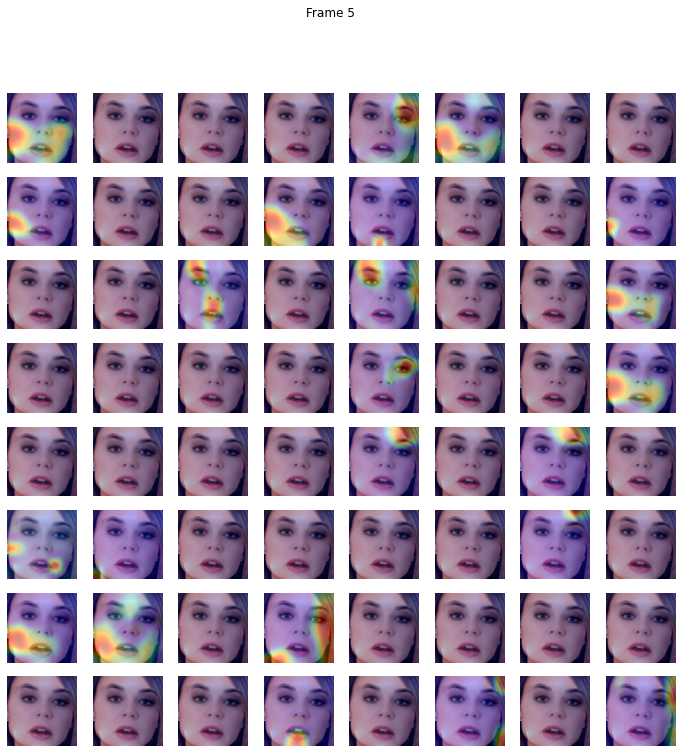

In [ ]:
heatmaps([act1,act2,act3,act4,act5],[t1,t2,t3,t4,t5])

In [ ]:
t1.shape

(1, 299, 299, 3)

In [ ]:
t1_single = np.squeeze(t1)

In [ ]:
np.amax((t1_single+1)/2)

1.0

time_distributed_9 (1, 8, 8, 64) 


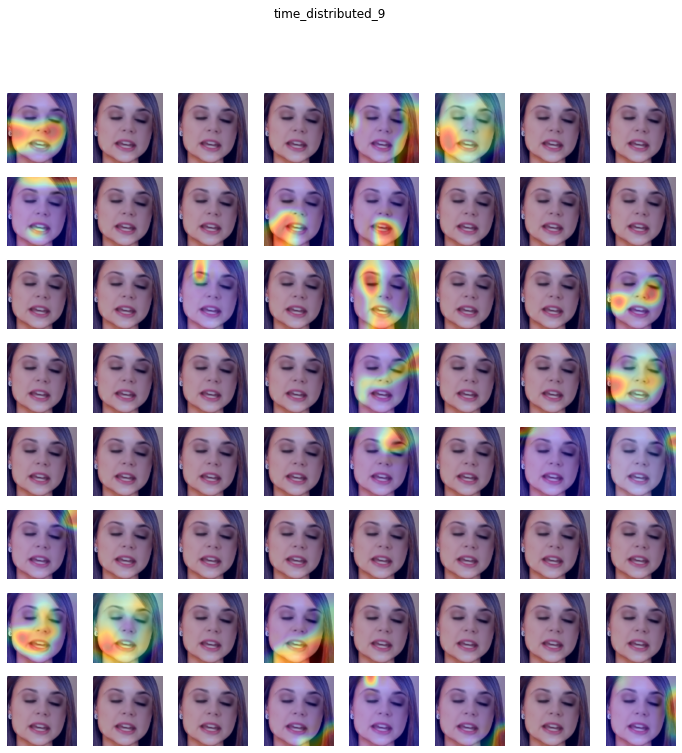

In [ ]:
max_img = heatmaps(new, t1)

In [ ]:
t2_single = np.squeeze(t2)

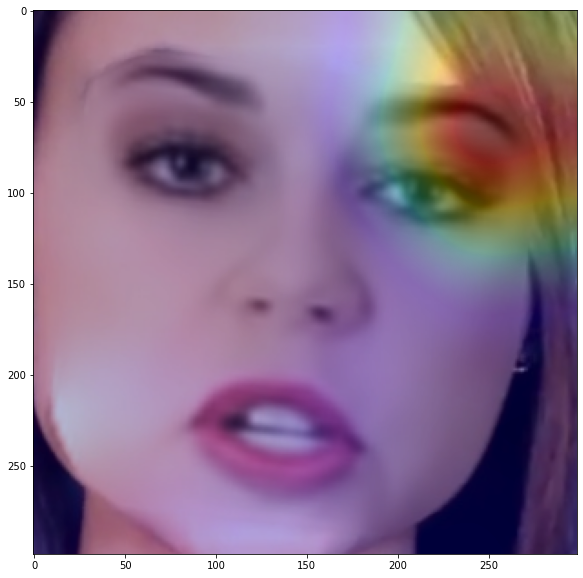

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow((t2_single+1)/2)
plt.imshow(max_img, alpha=0.3, cmap='jet', interpolation='bilinear')